# Mask R-CNN Image Segmentation Demo
This Colab enables you to use a Mask R-CNN model that was trained on Cloud TPU to perform instance segmentation on a sample input image. The resulting predictions are overlayed on the sample image as boxes, instance masks, and labels. You can also experiment with your own images by editing the input image URL.

### About Mask R-CNN
The Mask R-CNN model addresses one of the most difficult computer vision challenges: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," which means that different instances of the same type of object in the input image, for example, car, should be assigned distinct labels.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free Cloud TPU</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Download the source code
Download the source code of the Mask R-CNN model.

In [1]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 12016, done.
remote: Counting objects: 100% (2218/2218), done.
remote: Compressing objects: 100% (1052/1052), done.
remote: Total 12016 (delta 1248), reused 1930 (delta 1119), pack-reused 9798 (from 1)
Receiving objects: 100% (12016/12016), 47.13 MiB | 28.66 MiB/s, done.
Resolving deltas: 100% (8286/8286), done.


In [17]:
!pip install tensorflow-object-detection-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.2/769.2 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844489 sha256=27355af295fb3ad0e97cb8d564c

## Import libraries

In [2]:
from IPython import display
from PIL import Image
import numpy as np
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [3]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

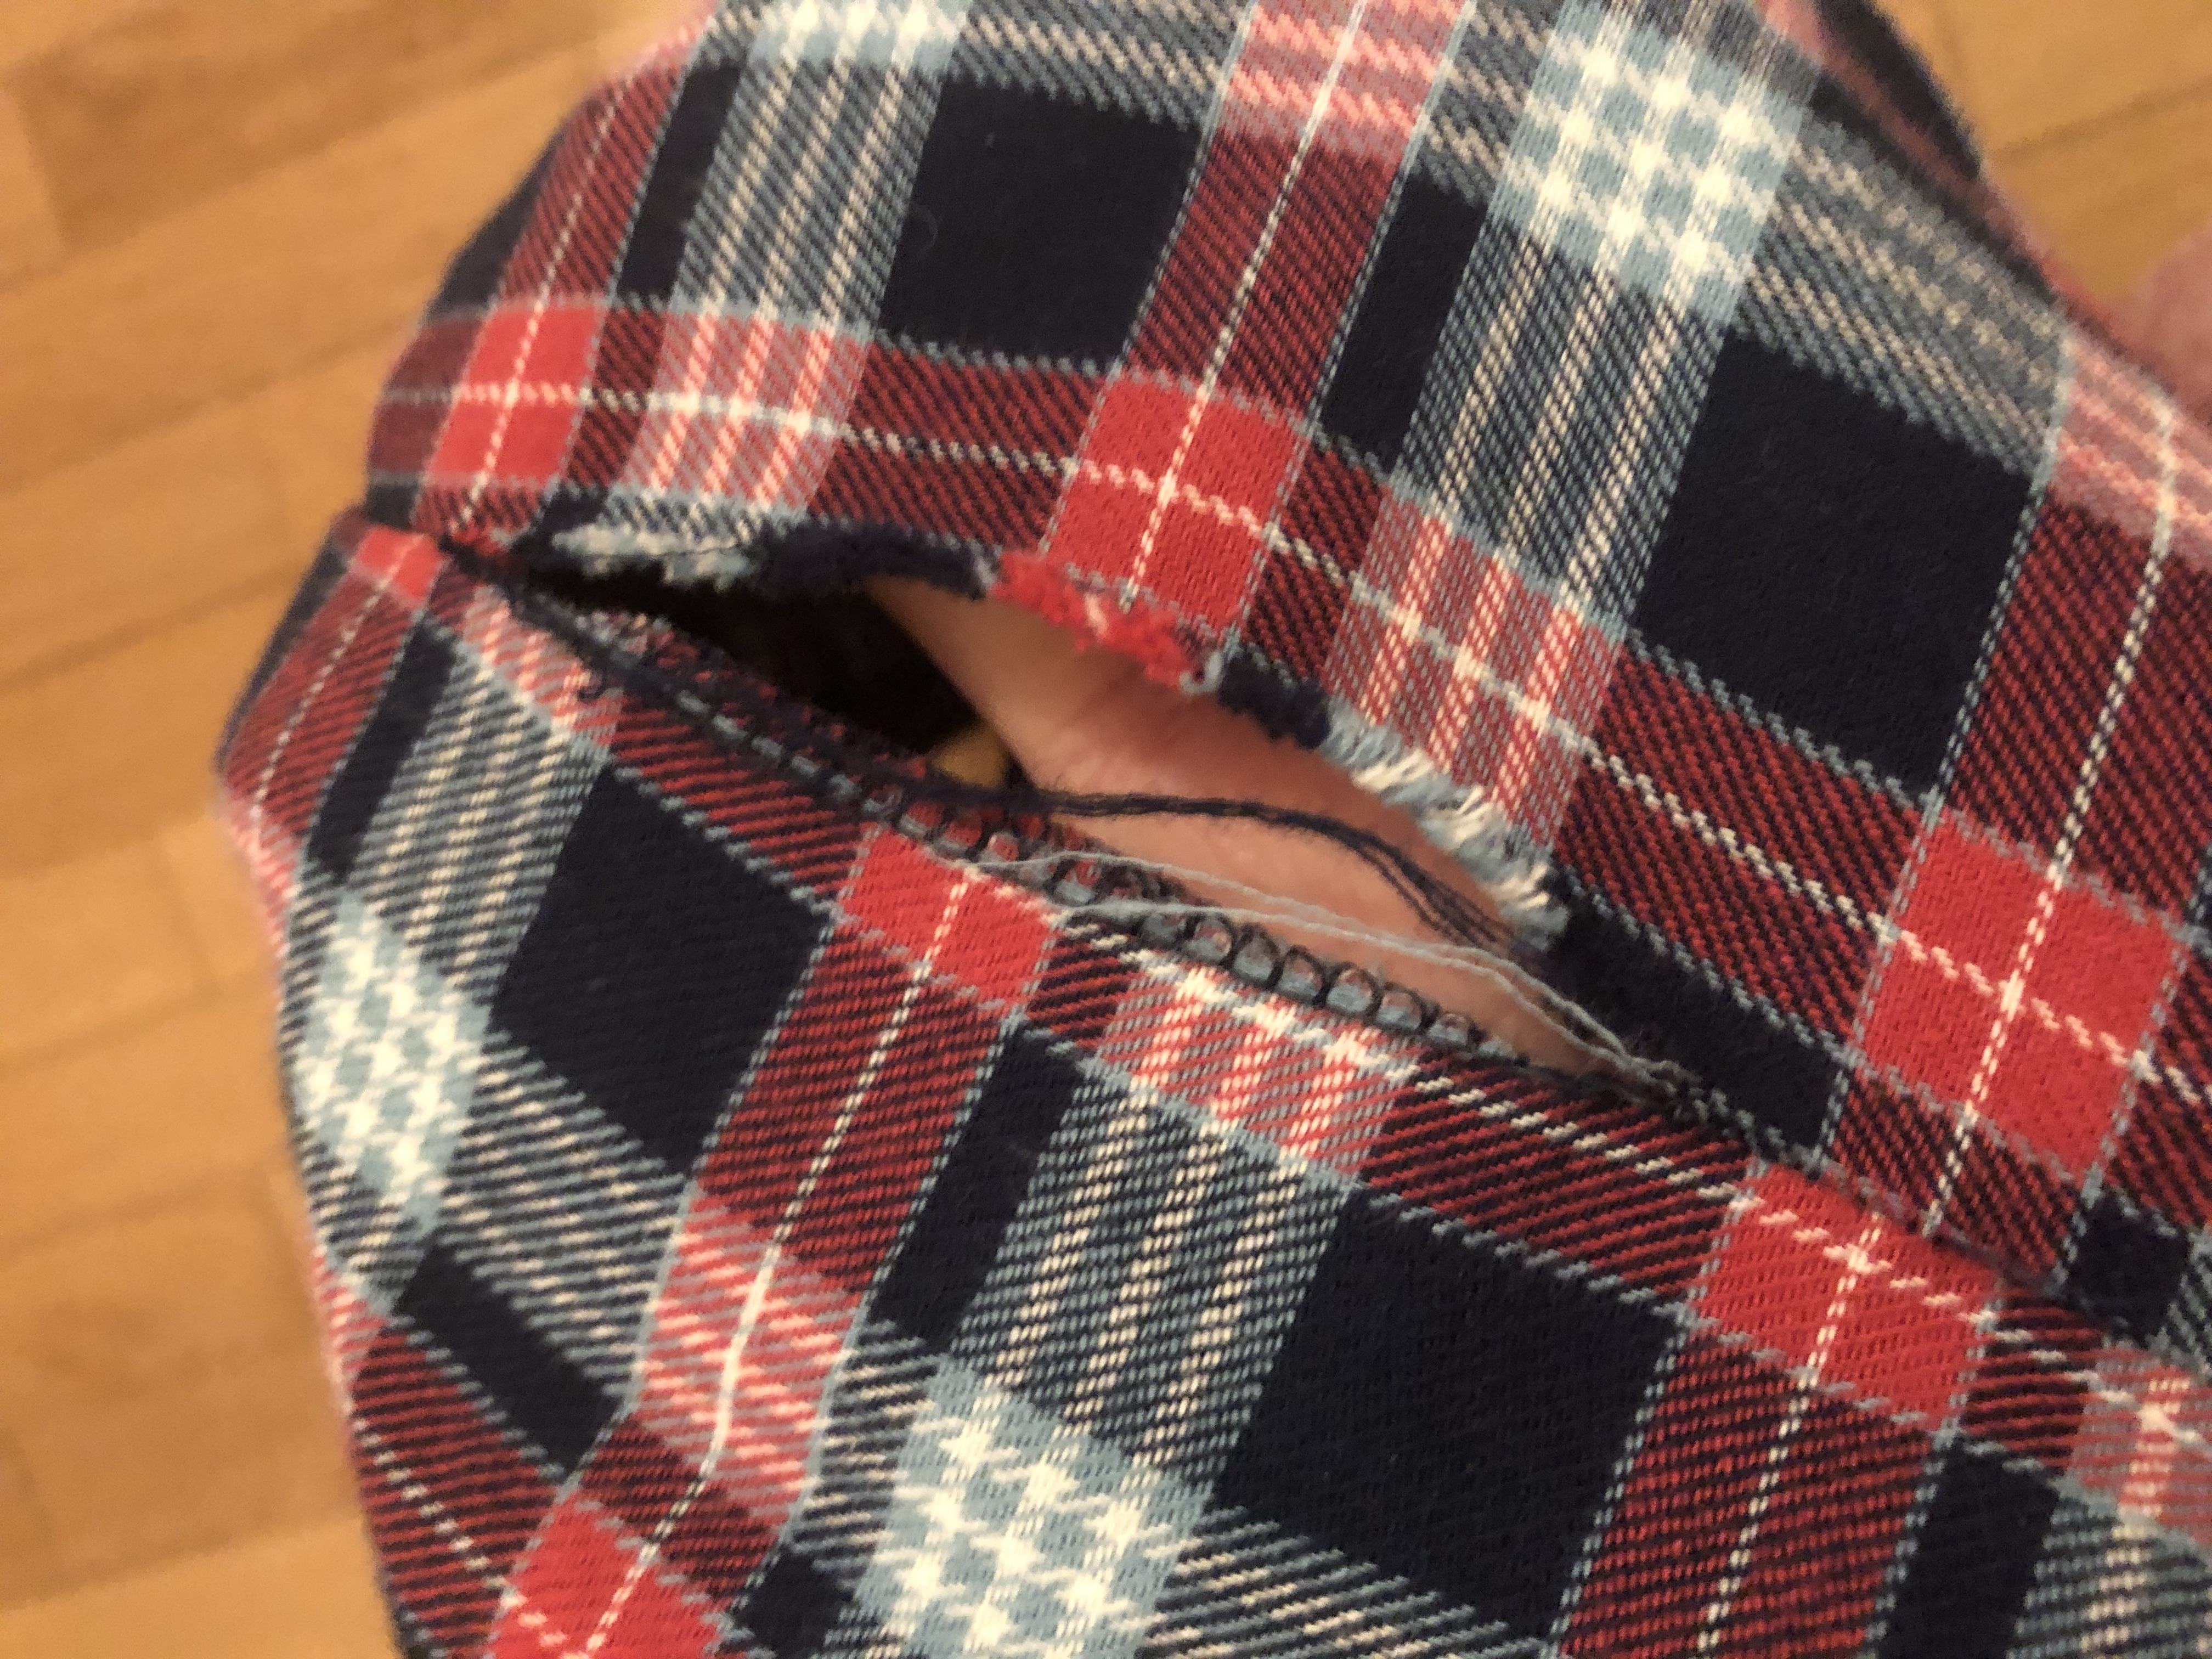

In [4]:
image_path = 'test.jpeg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [6]:
import os
import tensorflow as tf
import pprint

use_tpu = False  # Changez en False pour utiliser CPU ou GPU

if use_tpu:
    # Vérifiez si le TPU est disponible
    assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
    TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print('TPU address is', TPU_ADDRESS)

    # Connectez le TPU
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)

    print("TPU devices:", tf.config.list_logical_devices('TPU'))
else:
    # Utilisation CPU ou GPU
    print("Using CPU/GPU runtime")
    strategy = tf.distribute.get_strategy()

Using CPU/GPU runtime


# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket.

In [8]:
import tensorflow as tf

# Chemin vers le modèle sauvegardé
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'  # Spécifiez votre chemin

# Charger le modèle
model = tf.saved_model.load(saved_model_dir)

# Afficher les signatures disponibles
print("Signatures disponibles dans le modèle :")
for key in model.signatures:
    print(f"- {key}")


Signatures disponibles dans le modèle :
- serving_default


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [13]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Charger une image depuis un fichier
image_path = 'test.jpeg'  # Remplacez par le chemin réel de votre image
image = Image.open(image_path)

# Optionnel : Redimensionnez l'image si nécessaire (par exemple, pour le modèle)
image = image.resize((1024, 1024))  # Ajustez les dimensions selon les besoins du modèle

# Convertir l'image en tableau NumPy
np_image_string = np.array(image)

# Ajouter une dimension batch pour le tenseur (format [1, height, width, channels])
image_tensor = tf.convert_to_tensor(np.expand_dims(np_image_string, axis=0), dtype=tf.uint8)

# Vérifiez le tenseur
print("Tenseur d'entrée :", image_tensor.shape)


Tenseur d'entrée : (1, 1024, 1024, 3)


## Visualize the detection results
Time to check out the result!

In [16]:
import numpy as np
from PIL import Image
from object_detection.utils import visualization_utils as vis_utils
from IPython.display import display, Image as IPImage

# Paramètres
max_boxes_to_draw = 50  # Maximum de boîtes à afficher
min_score_thresh = 0.1  # Score minimum pour afficher une boîte

# Visualisation des boîtes de détection et des masques sur l'image
image_with_detections = vis_utils.visualize_boxes_and_labels_on_image_array(
    image=np_image,  # Image d'entrée au format NumPy
    boxes=detection_boxes,  # Boîtes détectées
    classes=detection_classes,  # Classes détectées
    scores=detection_scores,  # Scores des détections
    category_index=category_index,  # Index des catégories (id -> nom)
    instance_masks=segmentations,  # Masques des instances
    use_normalized_coordinates=False,  # Coordonnées absolues
    max_boxes_to_draw=max_boxes_to_draw,  # Limiter le nombre de boîtes
    min_score_thresh=min_score_thresh,  # Seuil pour afficher les boîtes
    agnostic_mode=False  # Si True, ignore les classes
)

# Enregistrer l'image avec les détections
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)

# Afficher l'image dans le notebook
display(IPImage(output_image_path, width=1024))


NameError: name 'vis_utils' is not defined

# What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* [Here's](https://cloud.google.com/tpu/docs/tutorials/mask-rcnn) a direct link to the Mask R-CNN tutorial.
